In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import random
import os
os.environ['KERAS_BACKEND'] = 'theano'
import keras
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Layer, Dense, Flatten, Conv2D, MaxPooling2D, Concatenate, Input, concatenate, Dropout, Cropping2D
from keras.optimizers import SGD



Using Theano backend.


In [2]:
nuc2vec={}
for i1,N1 in enumerate(["A","C","G","T"]):
        nuc2vec[N1]=i1

def seq2vec(seq):
    L=len(seq)
    vec=np.zeros((L,4))
    for i in range(L):
        j=nuc2vec[seq[i]]
        vec[i,j]=1
    return vec

def log_mse_loss(y_true,y_pred):
    log_mse = K.mean(K.square(K.log(y_pred+1)-K.log(y_true+1)),axis=-1)
    return log_mse

In [3]:
wholeDF = pickle.load(open("/home/groups/song/songlab2/somangk2/jupyter/jupyter/PrimeEditor/wholeDF.pkl","rb"))


In [4]:
EP = np.array(wholeDF["Measured PE efficiency"])
EP = np.where(EP>0, EP, 0)
M = int(max(EP))+1
bins = np.arange(0,M+1,1)
EP_binned, _, _ = plt.hist(EP, bins=bins)
plt.close("all")

ER2weight = {}
for i in range(M):
    if EP_binned[i]>EP_binned[30]:
        ER2weight[i] = EP_binned[30]/EP_binned[i]
    else:
        ER2weight[i] = 1
        
def sample_weight(EP_array):
    return np.array([ER2weight[int(i)] for i in list(EP_array.flatten())])

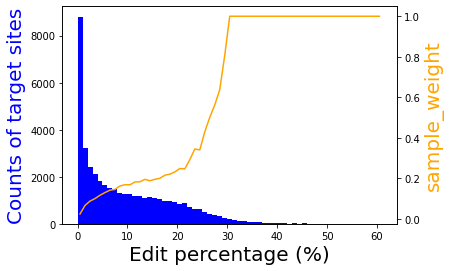

In [5]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

aa,bb,cc = ax1.hist(EP, bins=bins, color="blue")
x = bb[1:M]+.5
y = aa[1:M]
ax2.plot(bb[:M]+.5,sample_weight(bb[:M]+.5),color="orange")
ax1.set_xlabel("Edit percentage (%)", size=20)
ax1.set_ylabel("Counts of target sites", size=20, color="blue")
ax2.set_ylabel("sample_weight", size=20, color="orange")
plt.show()

In [6]:
seqs = list(set(wholeDF.iloc[:,2]))
random.shuffle(seqs)
N = len(seqs)
train_seqs = seqs[:int(N*0.8)]
vald_seqs = seqs[int(N*0.8):int(N*0.9)]
test_seqs = seqs[int(N*0.9):]

# filepath="/home/groups/song/songlab2/somangk2/jupyter/jupyter/PrimeEditor/NN/semifinal/test1/"
# [train_seqs, vald_seqs, test_seqs] = pickle.load(open(filepath+"index.pkl","rb"))

ERdf = {}
for seq in seqs:
    ERdf[seq] = wholeDF[wholeDF.iloc[:,2]==seq][["PBS length", "RT length", "Measured PE efficiency"]]
seq_arrays = {}
ERs = {}
data_lst = {}
for S, seqs in zip(["train","test","vald"],[train_seqs, test_seqs, vald_seqs]):
    seq_arrays[S] = []
    ERs[S] = []
    for seq in seqs:
        seq_array = seq2vec(seq).reshape((1,47,4))
        for PBS, RT, ER in zip(ERdf[seq]["PBS length"], ERdf[seq]["RT length"], ERdf[seq]["Measured PE efficiency"]):
            indicator = np.zeros((1,47,1))
            indicator[:,21-PBS:21+RT,:]=1
            seq_arrays[S].append(np.concatenate([seq_array,indicator], axis=2))
            ERs[S].append(ER)
    seq_arrays[S] = np.concatenate(seq_arrays[S])
    seq_arrays[S] = seq_arrays[S].reshape((-1,1,47,5))
    ERs[S] = np.array(ERs[S]).reshape((-1,1))
    ERs[S] = np.where(ERs[S]>0, ERs[S], 0)
    data_lst[S] = [seq_arrays[S],ERs[S]]

In [7]:
###Construct a CNN model - divide into small regions+convolutional filter - without Reshape

filterN = 10
filterL = 8

coef_array_ave = np.zeros((filterN,1,47,5))

maxlen=47
input_shape = (1,maxlen,5)
inp = Input(shape=input_shape)
drop1 = Dropout(0.2)(inp)

region = {}
conv2 = {}
for k in range(47-filterL+1):
    region[k] = Cropping2D(cropping=((0,0),(k,47-filterL-k)))(drop1)
    conv2[k] = Conv2D(filterN,kernel_size=(filterL,5),strides=(1,5), \
                      activation='relu',padding='valid', data_format="channels_first")(region[k])

merged = Concatenate(axis=-2)([conv2[k] for k in range(47-filterL+1)])
drop2 = Dropout(0.2)(merged)
flt2 = Flatten()(drop2)
dns = Dense(10, activation='relu')(flt2)
outp = Dense(1, activation='relu')(dns)
model = Model(inputs=inp,outputs=outp)

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 47, 5)     0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1, 47, 5)     0           input_1[0][0]                    
__________________________________________________________________________________________________
cropping2d_1 (Cropping2D)       (None, 1, 8, 5)      0           dropout_1[0][0]                  
__________________________________________________________________________________________________
cropping2d_2 (Cropping2D)       (None, 1, 8, 5)      0           dropout_1[0][0]                  
__________________________________________________________________________________________________
cropping2d

conv2d_3 (Conv2D)               (None, 10, 1, 1)     410         cropping2d_3[0][0]               
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 10, 1, 1)     410         cropping2d_4[0][0]               
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 10, 1, 1)     410         cropping2d_5[0][0]               
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 10, 1, 1)     410         cropping2d_6[0][0]               
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 10, 1, 1)     410         cropping2d_7[0][0]               
__________________________________________________________________________________________________
conv2d_8 (

Total params: 20,421
Trainable params: 20,421
Non-trainable params: 0
__________________________________________________________________________________________________


In [8]:
###Compile and fit
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=log_mse_loss,optimizer=sgd,metrics=[log_mse_loss])

In [9]:
###Train
batch_size = 100
epochs = 1000
patience = 100


filepath="./NN/test5/"
if not os.path.exists(filepath):
    os.makedirs(filepath) 
filename = "{epoch:03d}-{loss:.4f}-{log_mse_loss:.4f}-{val_loss:.4f}-{val_log_mse_loss:.4f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath+filename)
earlystop = keras.callbacks.EarlyStopping(monitor='val_log_mse_loss', patience=patience)
callbacks_list = [checkpoint,earlystop]

pickle.dump([train_seqs, vald_seqs, test_seqs], open(filepath+"index.pkl","wb"))

model.fit(data_lst["train"][0],data_lst["train"][1],
          sample_weight=sample_weight(data_lst["train"][1]),
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(data_lst["vald"][0],data_lst["vald"][1],sample_weight(data_lst["vald"][1])),
          callbacks = callbacks_list)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Train on 34590 samples, validate on 4295 samples
Epoch 1/1000
 - 4s - loss: 0.3629 - log_mse_loss: 1.6620 - val_loss: 0.1443 - val_log_mse_loss: 1.2695
Epoch 2/1000
 - 4s - loss: 0.1229 - log_mse_loss: 1.5702 - val_loss: 0.1194 - val_log_mse_loss: 1.5119
Epoch 3/1000
 - 4s - loss: 0.1163 - log_mse_loss: 1.7395 - val_loss: 0.1163 - val_log_mse_loss: 1.5906
Epoch 4/1000
 - 4s - loss: 0.1155 - log_mse_loss: 1.7976 - val_loss: 0.1154 - val_log_mse_loss: 1.6102
Epoch 5/1000
 - 4s - loss: 0.1148 - log_mse_loss: 1.8040 - val_loss: 0.1149 - val_log_mse_loss: 1.6154
Epoch 6/1000
 - 4s - loss: 0.1145 - log_mse_loss: 1.8098 - val_loss: 0.1146 - val_log_mse_loss: 1.6093
Epoch 7/1000


KeyboardInterrupt: 